# (08) Reservoir + GLM
**Motivation**: Very competetive models with Resrvoir + GLM. This notebook: ```expt=clu090```.

## Approach:
1. STA
2. find best_lag
3. at best_lag, find best $(i, j)$
4. Additionally, you can find best filters as well.
5. Finally, fit a GLM at best-lag and best $(i, j)$ using all or a subset of filters.
<br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from torch.nn import functional as F
from sklearn.decomposition import PCA

from analysis.glm import prepare_data, extract_features
from analysis.linear import LinearModel, flatten_stim, compute_sta
from base.dataset import setup_supervised_data, setup_repeat_data, time_embed

## Create reservoir

In [3]:
vae = VAE(ConfigVAE(h_pre='simulation_dim-19_5e+04', ker_sz=4, input_sz=19))
tr = TrainerVAE(vae, ConfigTrainVAE(batch_size=350), device='cuda')
vae.print()
print(vae.cfg.name())
vae.scales, vae.cfg.total_latents()

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.0 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.4 Mil   |
| dec_sampler  |  1.4 Mil   |
|    expand    |   71.0 K   |
|  dec_tower   |  4.5 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)

([8, 4], 210)

## Load neuron

In [4]:
expt = 'clu090'
kws_hf = dict(size=19, sres=1, radius=6)
stim, spks, good, stim_r, spks_r, good_r = prepare_data(
    expt=expt,
    tr=tr,
    kws_hf=kws_hf,
    rescale=2.25,
)
stim.shape, stim_r.shape

((72000, 2, 19, 19), (613, 2, 19, 19))

## Extract ftrs

In [6]:
kws_process = dict(scale=4, pool='max', act_fn='swish')
enc, enc_r = extract_features(
    tr=tr,
    stim=stim,
    stim_r=stim_r,
    kws_process=kws_process,
    which='enc',
    use_ema=True,
)
enc.shape, enc_r.shape

100%|█████████████████████████████████████████| 206/206 [01:18<00:00,  2.62it/s]


((72000, 5312, 4, 4), (613, 5312, 4, 4))

In [7]:
mu, sd = enc.mean(), enc.std()

enc_r = (enc_r - mu) / sd
enc = (enc - mu) / sd

print(f"(before) - - - \t mu: {mu}, sd: {sd}")

(before) - - -   mu: 0.026397444307804108, sd: 0.12137231230735779

In [6]:
# was use_ema=True, and float

(before) - - -   mu: 0.026398077516967346, sd: 0.12137023252225511

In [6]:
# was use_ema=False

(before) - - -   mu: 0.029923408880239543, sd: 0.1049725525820159

## STA

In [8]:
lags = 29
sta = compute_sta(
    lags=lags,
    good=good,
    stim=enc,
    spks=spks,
    zscore=True,
    verbose=True,
)
sta.shape

100%|████████████████████████████████████| 54376/54376 [08:08<00:00, 111.35it/s]


(1, 30, 5312, 4, 4)

In [9]:
sta.mean(), sta.std()

(0.0127999974561505, 0.07384881158034023)

In [8]:
# was use_ema=True, and float

(0.012799943483789596, 0.07384833211526548)

In [8]:
# was use_ema=False

(0.01340770330830717, 0.08258121762893599)

100%|████████████████████████████████████| 54376/54376 [07:52<00:00, 115.08it/s]


(1, 30, 5312, 4, 4)

In [10]:
dims = (2, 3, 4)
norm = np.mean(sta ** 2, axis=dims)
best_lag = np.argmax(norm[:, ::-1], axis=1)
norm.shape

(1, 30)

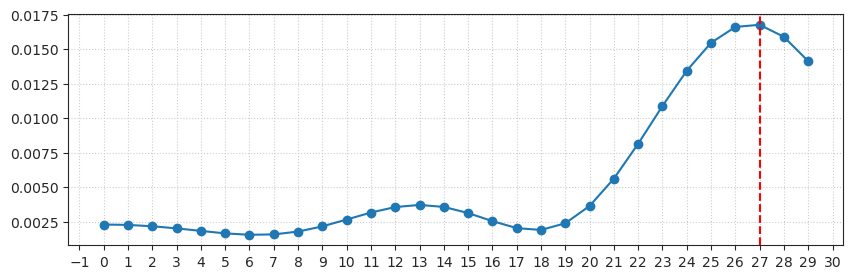

In [11]:
fig, ax = create_figure(1, 1, (10, 3))
ax.plot(norm[0], marker='o')
plt.axvline(lags - best_lag[0], color='r', ls='--')
ax.locator_params(axis='x', nbins=lags * 1.2)
ax.grid()

In [12]:
best_lag

array([2])

In [13]:
dims = (1, 2)
norm = sta[0][best_lag[0]]
norm = np.mean(norm ** 2, axis=dims)

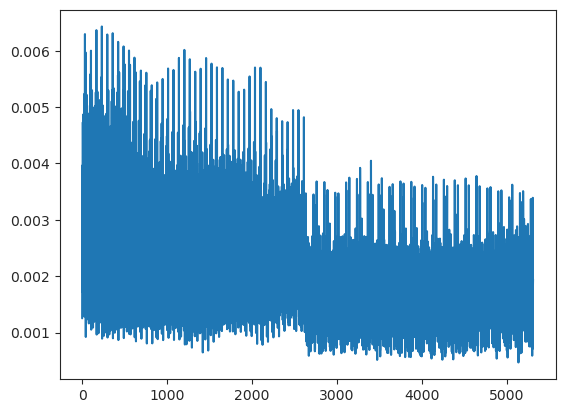

In [14]:
plt.plot(norm);

In [15]:
best_filts = np.argsort(norm)[::-1]
best_filts[0]

232

In [14]:
# was use_ema=True, and float

232

In [16]:
dims = (0,)
norm = sta[0][best_lag[0]]
norm = np.mean(norm ** 2, axis=dims)
best_i, best_j = np.unravel_index(np.argmax(norm), norm.shape)
best_i, best_j

(2, 3)

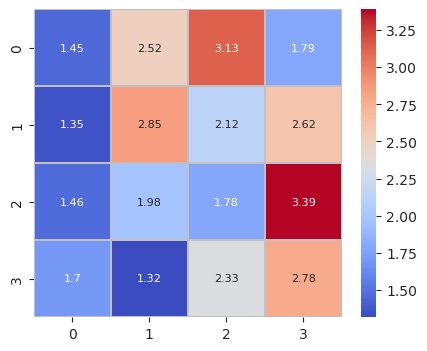

In [17]:
show_heatmap(norm * 1000, cmap='coolwarm', vmin=None, vmax=None, fmt='1.3g', figsize=(5, 4));

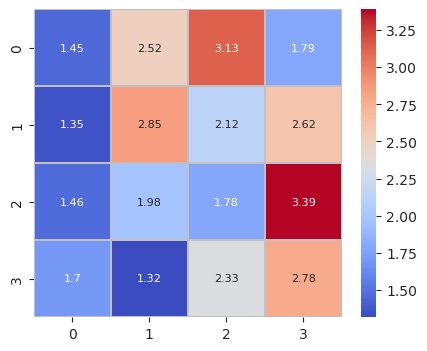

In [16]:
# was use_ema=True, and float

In [18]:
neuron_i = 0

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

x = enc[idxs - best_lag[0], :, best_i, best_j]
x_r = enc_r[good_r - best_lag[0], :, best_i, best_j]

mu = x.mean(0, keepdims=True)
sd = x.std(0, keepdims=True)

x = (x - mu) / sd
x_r = (x_r - mu) / sd

x.shape, x_r.shape

((54386, 5312), (200, 5312))

In [19]:
%%time

glm_kws = dict(
    category='PoissonRegressor',
    x=x,
    y=spks[idxs, neuron_i],
    x_tst=x_r,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[0.05, 0.1, 0.3],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=2000)
print(glm.r2_tst)

{0.05: 73.14807198615773, 0.1: 74.49893808868784, 0.3: 73.6519646782896}

CPU times: user 34min 11s, sys: 4min 21s, total: 38min 33s
Wall time: 8min 40s


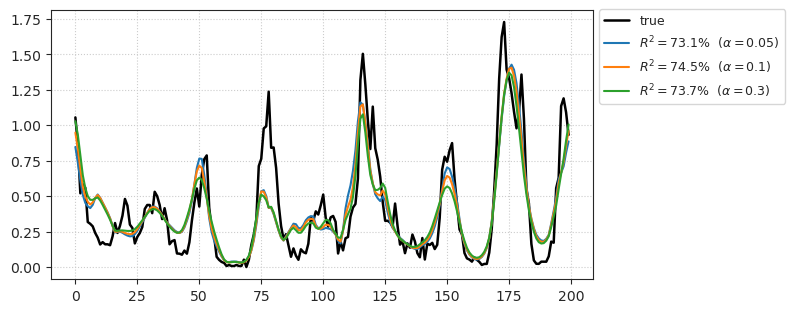

In [20]:
glm.show_pred();

In [18]:
# was use_ema=True, and float

{0.05: 73.11380198078066, 0.1: 74.47373810567744, 0.3: 73.64498810236884}

CPU times: user 27min 52s, sys: 1.24 s, total: 27min 54s
Wall time: 1min 7s


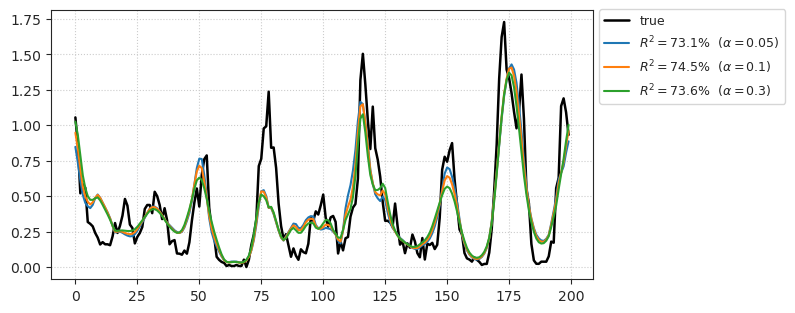

In [19]:
# was use_ema=True, and float

In [20]:
glm.r_tst

{0.05: 0.8601345821928108, 0.1: 0.8712829352047585, 0.3: 0.872233006963891}

In [18]:
## was with use_ema = False

{0.05: 67.83655056285806, 0.1: 67.79131465485254, 0.3: 66.96766611455784}

CPU times: user 27min 24s, sys: 1.97 s, total: 27min 26s
Wall time: 1min 6s


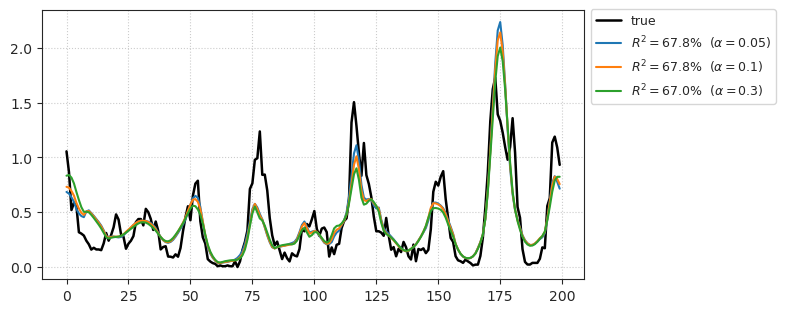

In [19]:
## was with use_ema = False

{0.05: 0.8265533354282735, 0.1: 0.8251901704761364, 0.3: 0.8187352138780093}

In [18]:
# glm.r2_tst

{0.05: 61.01773770104239, 0.1: 58.983193874749, 0.3: 57.24371124160588}

In [27]:
# glm.r_tst

{0.05: 0.7847488582270137, 0.1: 0.7749374216621111, 0.3: 0.7605836937912276}

In [54]:
glm_kws = dict(
    category='PoissonRegressor',
    x=x,
    y=spks[idxs, neuron_i],
    x_tst=x_r,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[0.008, 0.01, 0.02, 0.05, 0.1],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=1000)

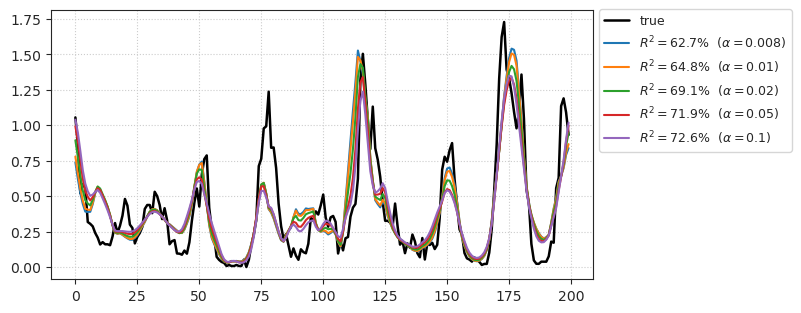

In [55]:
glm.show_pred();

In [56]:
glm.r2_tst

{0.008: 62.70357790089165,
 0.01: 64.75651722373046,
 0.02: 69.08208333033959,
 0.05: 71.89748923945032,
 0.1: 72.59063471455232}

In [57]:
glm.r_tst

{0.008: 0.7955234261745721,
 0.01: 0.806340089467274,
 0.02: 0.8313864266944123,
 0.05: 0.8535938502725418,
 0.1: 0.8609733727662682}

### Zscore? (best achieved so far)

In [63]:
%%time

mu = x.mean(0, keepdims=True)
sd = x.std(0, keepdims=True)

glm_kws = dict(
    category='PoissonRegressor',
    x=(x - mu) / sd,
    y=spks[idxs, neuron_i],
    x_tst=(x_r - mu) / sd,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[0.05, 0.1, 0.3],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=2000)

CPU times: user 31min 48s, sys: 4min 12s, total: 36min 1s
Wall time: 8min 12s


In [64]:
glm.r2_tst

{0.05: 73.07986679064378, 0.1: 74.46667052088276, 0.3: 73.65298415540046}

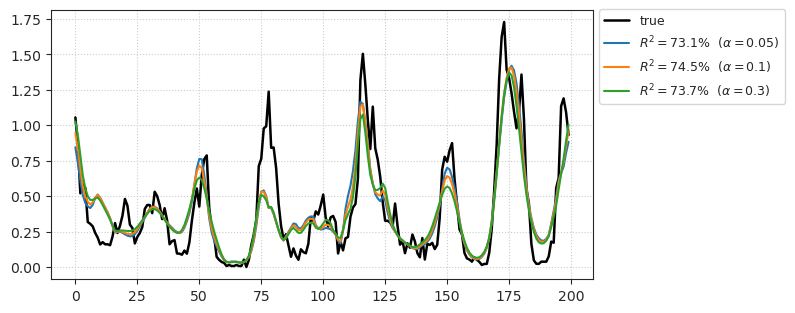

In [65]:
glm.show_pred();

In [66]:
glm.r_tst

{0.05: 0.8603080514050138, 0.1: 0.8711900110145165, 0.3: 0.8722191619147348}

### Now all filters

In [42]:
%%time

neuron_i = 0

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

glm_kws = dict(
    category='PoissonRegressor',
    x=enc[idxs - best_lag[0], :, best_i, best_j],
    y=spks[idxs, neuron_i],
    x_tst=enc_r[intvl - best_lag[0], :, best_i, best_j],
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[0.01, 0.1, 1],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=1000)


KeyboardInterrupt



In [43]:
glm.show_pred();


KeyboardInterrupt



<Figure size 700x350 with 0 Axes>

In [63]:
%%time

neuron_i = 0
best_i, best_j = 2, 3

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

glm_kws = dict(
    category='PoissonRegressor',
    x=enc[idxs - best_lag[0], :, best_i, best_j],
    y=spks[idxs, neuron_i],
    x_tst=enc_r[intvl - best_lag[0], :, best_i, best_j],
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[0.01, 0.1, 1],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=1000)

CPU times: user 1h 10min 38s, sys: 9min 5s, total: 1h 19min 44s
Wall time: 17min 56s


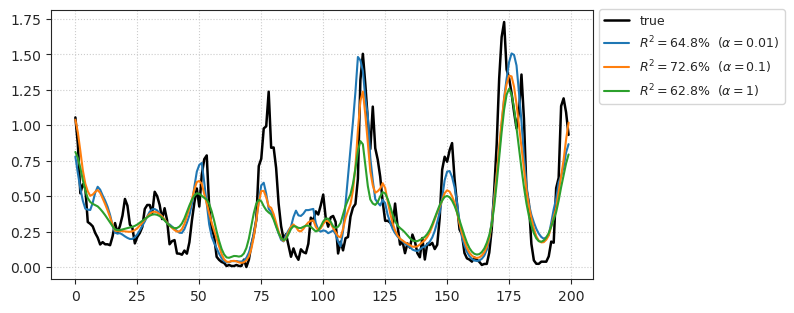

In [64]:
glm.show_pred();

## Note:

- Best model so far, obtained by first picking the top lag, and USING THE SAME LAG, picking the best location (i, j).
- Next, I will just choose the best overall location using all lags, and time embed (lags=10) the top 100 filters only. This will yield a 100 x 10 dimensional feature space to choose from.

## Fresh copy

In [67]:
dims = (2, 3, 4)
norm = np.mean(sta ** 2, axis=dims)
best_lag = np.argmax(norm[:, -5:][:, ::-1], axis=1)
norm.shape

(1, 30)

In [68]:
best_lag

array([2])

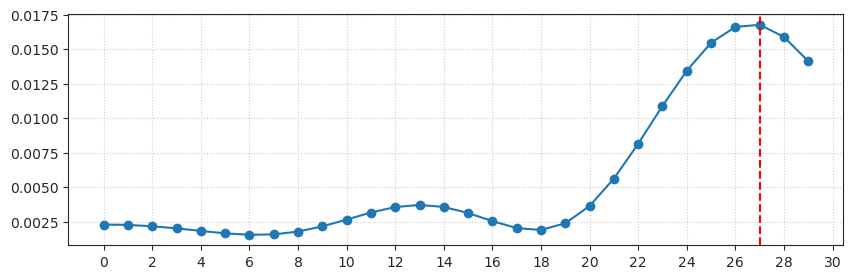

In [69]:
fig, ax = create_figure(1, 1, (10, 3))
ax.plot(norm[0], marker='o')
plt.axvline(lags - best_lag[0], color='r', ls='--')
ax.locator_params(axis='x', nbins=25)
ax.grid();

In [70]:
sta.shape

(1, 30, 5312, 4, 4)

In [71]:
dims = (1, 3, 4)
norm = np.mean(sta ** 2, axis=dims)
norm.shape

(1, 5312)

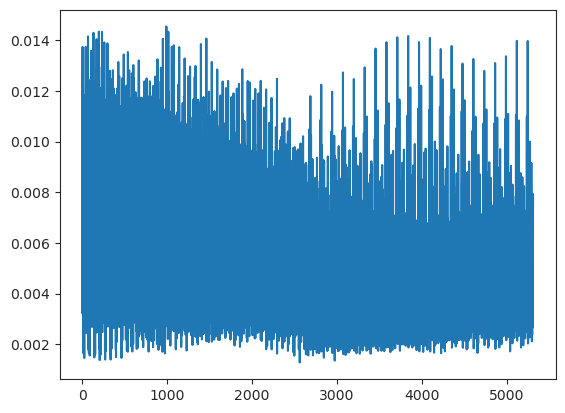

In [72]:
plt.plot(norm[0]);

In [75]:
best_filts = np.argsort(norm[0])[::-1]
best_filts[0]

992

In [80]:
dims = (1, 2)
norm = np.mean(sta ** 2, axis=dims)
best_i, best_j = np.unravel_index(np.argmax(norm[0]), norm[0].shape)
best_i, best_j

(1, 2)

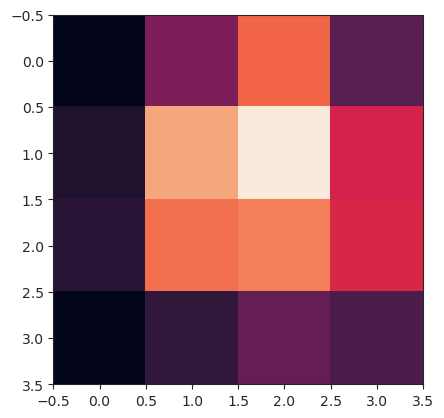

In [82]:
plt.imshow(norm[0])

### Top 100 filters

In [95]:
src = time_embed(enc[:, best_filts[:100], best_i, best_j], lags=12, idxs=good)
src_r = time_embed(enc_r[:, best_filts[:100], best_i, best_j], lags=12, idxs=intvl)
src.shape, src_r.shape

((54386, 12, 100), (200, 12, 100))

In [96]:
best_i, best_j

(1, 2)

In [106]:
neuron_i = 0

idxs = good.copy()
idxs = idxs[idxs > best_lag[neuron_i]]

glm_kws = dict(
    category='PoissonRegressor',
    x=src,
    y=spks[idxs, neuron_i],
    x_tst=src_r,
    y_tst=np.nanmean(spks_r[neuron_i], 0),
    alphas=[0.001, 0.005, 0.01, 0.03],
)
glm = LinearModel(**glm_kws).fit(fit_df=False, max_iter=1000)

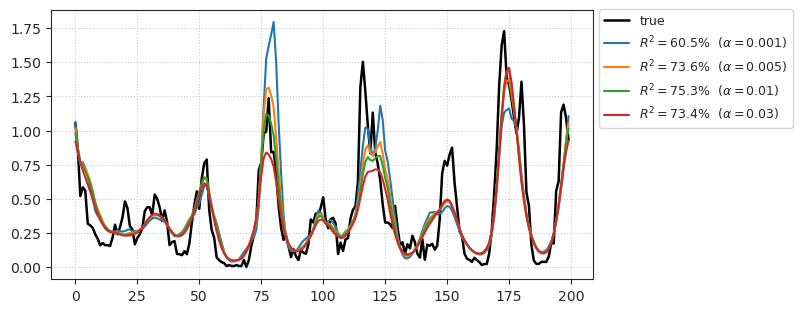

In [107]:
glm.show_pred();

In [108]:
glm.r2_tst

{0.001: 60.496093709018616,
 0.005: 73.60548406718837,
 0.01: 75.25045440592415,
 0.03: 73.39225126513337}

In [109]:
glm.r_tst

{0.001: 0.7891028743126074,
 0.005: 0.8593102090117459,
 0.01: 0.87312377051065,
 0.03: 0.875822593453024}

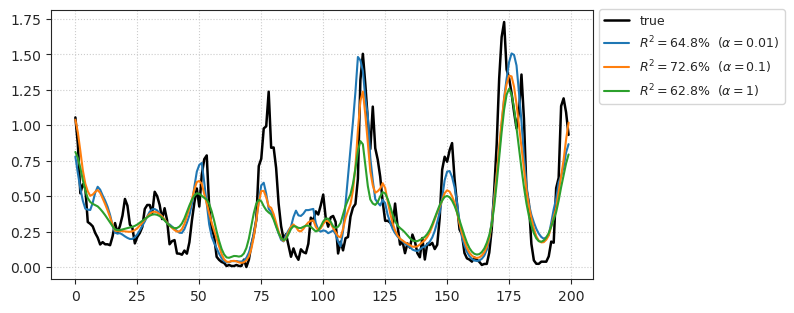

In [64]:
## Was best loc = 2,3, at best lag = 2